In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "all"
z_range = "all_z"
key = "z"
quantile = "1"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

1it [00:00,  3.30it/s]

12it [00:00,  4.65it/s]

22it [00:00,  6.51it/s]

34it [00:00,  9.07it/s]

45it [00:00, 12.48it/s]

55it [00:00, 16.86it/s]

67it [00:00, 22.70it/s]

79it [00:01, 29.98it/s]

91it [00:01, 38.61it/s]

103it [00:01, 48.25it/s]

115it [00:01, 57.99it/s]

127it [00:01, 68.03it/s]

139it [00:01, 73.04it/s]

150it [00:01, 80.82it/s]

161it [00:01, 87.57it/s]

173it [00:01, 93.81it/s]

185it [00:02, 99.06it/s]

197it [00:02, 103.22it/s]

209it [00:02, 107.60it/s]

221it [00:02, 110.80it/s]

233it [00:02, 112.85it/s]

245it [00:02, 114.35it/s]

257it [00:02, 115.26it/s]

269it [00:02, 113.56it/s]

281it [00:02, 108.42it/s]

292it [00:02, 97.58it/s] 

303it [00:03, 91.59it/s]

313it [00:03, 88.39it/s]

323it [00:03, 85.34it/s]

335it [00:03, 91.83it/s]

347it [00:03, 98.41it/s]

359it [00:03, 103.68it/s]

371it [00:03, 107.70it/s]

383it [00:03, 106.23it/s]

395it [00:04, 109.13it/s]

407it [00:04, 110.60it/s]

420it [00:04, 113.26it/s]

432it [00:04, 113.81it/s]

444it [00:04, 115.20it/s]

456it [00:04, 115.43it/s]

468it [00:04, 116.11it/s]

480it [00:04, 113.78it/s]

492it [00:04, 106.66it/s]

504it [00:04, 110.14it/s]

516it [00:05, 112.56it/s]

528it [00:05, 114.59it/s]

540it [00:05, 111.53it/s]

552it [00:05, 106.93it/s]

564it [00:05, 109.89it/s]

576it [00:05, 95.39it/s] 

586it [00:05, 89.38it/s]

596it [00:05, 84.66it/s]

605it [00:06, 82.84it/s]

616it [00:06, 88.15it/s]

628it [00:06, 95.73it/s]

638it [00:06, 84.25it/s]

647it [00:06, 83.36it/s]

656it [00:06, 80.52it/s]

665it [00:06, 77.03it/s]

677it [00:06, 85.19it/s]

686it [00:06, 85.09it/s]

695it [00:07, 81.44it/s]

704it [00:07, 80.76it/s]

713it [00:07, 79.82it/s]

725it [00:07, 87.71it/s]

737it [00:07, 95.20it/s]

750it [00:07, 101.48it/s]

761it [00:07, 102.10it/s]

773it [00:07, 106.75it/s]

785it [00:07, 108.42it/s]

797it [00:08, 110.35it/s]

809it [00:08, 107.54it/s]

821it [00:08, 108.93it/s]

833it [00:08, 111.05it/s]

845it [00:08, 111.92it/s]

857it [00:08, 113.36it/s]

869it [00:08, 113.81it/s]

881it [00:08, 106.04it/s]

892it [00:08, 95.95it/s] 

902it [00:09, 84.25it/s]

911it [00:09, 85.72it/s]

923it [00:09, 93.42it/s]

935it [00:09, 99.93it/s]

947it [00:09, 104.79it/s]

958it [00:09, 105.47it/s]

970it [00:09, 106.16it/s]

981it [00:09, 92.80it/s] 

991it [00:10, 87.90it/s]

1001it [00:10, 90.08it/s]

1013it [00:10, 96.99it/s]

1024it [00:10, 94.54it/s]

1034it [00:10, 87.57it/s]

1044it [00:10, 81.01it/s]

1053it [00:10, 79.86it/s]

1062it [00:10, 79.53it/s]

1074it [00:10, 87.81it/s]

1086it [00:11, 95.34it/s]

1099it [00:11, 101.95it/s]

1111it [00:11, 105.91it/s]

1123it [00:11, 108.53it/s]

1135it [00:11, 96.67it/s] 

1146it [00:11, 90.92it/s]

1157it [00:11, 94.04it/s]

1168it [00:11, 97.84it/s]

1179it [00:12, 96.32it/s]

1190it [00:12, 99.79it/s]

1201it [00:12, 95.97it/s]

1213it [00:12, 101.72it/s]

1225it [00:12, 105.93it/s]

1237it [00:12, 109.55it/s]

1249it [00:12, 112.33it/s]

1261it [00:12, 109.38it/s]

1273it [00:12, 102.23it/s]

1284it [00:13, 100.35it/s]

1295it [00:13, 100.47it/s]

1307it [00:13, 104.80it/s]

1319it [00:13, 108.52it/s]

1331it [00:13, 111.56it/s]

1344it [00:13, 114.04it/s]

1356it [00:13, 115.33it/s]

1368it [00:13, 116.08it/s]

1380it [00:13, 117.05it/s]

1392it [00:13, 117.62it/s]

1404it [00:14, 117.73it/s]

1416it [00:14, 118.14it/s]

1428it [00:14, 118.68it/s]

1440it [00:14, 118.73it/s]

1452it [00:14, 119.10it/s]

1464it [00:14, 119.01it/s]

1476it [00:14, 119.28it/s]

1488it [00:14, 113.59it/s]

1500it [00:14, 105.81it/s]

1511it [00:15, 91.36it/s] 

1522it [00:15, 95.13it/s]

1535it [00:15, 101.53it/s]

1547it [00:15, 106.01it/s]

1558it [00:15, 106.43it/s]

1570it [00:15, 109.92it/s]

1583it [00:15, 112.80it/s]

1595it [00:15, 110.62it/s]

1607it [00:15, 110.04it/s]

1619it [00:15, 111.53it/s]

1631it [00:16, 96.37it/s] 

1643it [00:16, 101.41it/s]

1654it [00:16, 88.73it/s] 

1664it [00:16, 84.42it/s]

1675it [00:16, 90.41it/s]

1687it [00:16, 96.50it/s]

1699it [00:16, 102.08it/s]

1710it [00:16, 97.90it/s] 

1721it [00:17, 94.76it/s]

1733it [00:17, 100.89it/s]

1745it [00:17, 104.96it/s]

1757it [00:17, 108.35it/s]

1769it [00:17, 110.64it/s]

1781it [00:17, 112.59it/s]

1793it [00:17, 114.71it/s]

1805it [00:17, 107.92it/s]

1817it [00:17, 110.14it/s]

1829it [00:18, 110.96it/s]

1841it [00:18, 112.18it/s]

1853it [00:18, 110.65it/s]

1865it [00:18, 112.36it/s]

1877it [00:18, 114.12it/s]

1889it [00:18, 115.23it/s]

1901it [00:18, 115.91it/s]

1913it [00:18, 116.13it/s]

1925it [00:18, 115.79it/s]

1937it [00:19, 111.79it/s]

1949it [00:19, 112.08it/s]

1961it [00:19, 112.96it/s]

1973it [00:19, 112.98it/s]

1985it [00:19, 113.12it/s]

1997it [00:19, 114.91it/s]

2009it [00:19, 115.17it/s]

2021it [00:19, 116.13it/s]

2033it [00:19, 115.64it/s]

2045it [00:19, 113.05it/s]

2057it [00:20, 114.08it/s]

2069it [00:20, 113.47it/s]

2081it [00:20, 106.02it/s]

2093it [00:20, 109.18it/s]

2105it [00:20, 101.12it/s]

2116it [00:20, 91.03it/s] 

2127it [00:20, 94.71it/s]

2139it [00:20, 100.59it/s]

2152it [00:20, 105.90it/s]

2164it [00:21, 109.42it/s]

2177it [00:21, 112.78it/s]

2189it [00:21, 114.44it/s]

2201it [00:21, 115.81it/s]

2214it [00:21, 117.41it/s]

2227it [00:21, 118.52it/s]

2239it [00:21, 118.24it/s]

2251it [00:21, 116.80it/s]

2263it [00:21, 117.09it/s]

2275it [00:22, 117.23it/s]

2287it [00:22, 117.00it/s]

2299it [00:22, 112.43it/s]

2311it [00:22, 114.07it/s]

2323it [00:22, 115.34it/s]

2335it [00:22, 99.23it/s] 

2346it [00:22, 93.53it/s]

2356it [00:22, 88.02it/s]

2368it [00:22, 94.87it/s]

2380it [00:23, 100.98it/s]

2392it [00:23, 105.94it/s]

2405it [00:23, 109.96it/s]

2417it [00:23, 112.55it/s]

2429it [00:23, 113.58it/s]

2441it [00:23, 115.12it/s]

2454it [00:23, 116.57it/s]

2466it [00:23, 116.66it/s]

2478it [00:23, 115.01it/s]

2490it [00:24, 114.37it/s]

2502it [00:24, 97.44it/s] 

2513it [00:24, 89.63it/s]

2524it [00:24, 94.63it/s]

2536it [00:24, 98.09it/s]

2548it [00:24, 102.93it/s]

2560it [00:24, 105.59it/s]

2572it [00:24, 109.01it/s]

2584it [00:24, 108.97it/s]

2596it [00:25, 111.72it/s]

2608it [00:25, 111.61it/s]

2620it [00:25, 110.92it/s]

2632it [00:25, 108.88it/s]

2643it [00:25, 98.41it/s] 

2654it [00:25, 101.48it/s]

2665it [00:25, 102.52it/s]

2677it [00:25, 106.34it/s]

2689it [00:25, 109.53it/s]

2701it [00:26, 107.68it/s]

2712it [00:26, 92.90it/s] 

2724it [00:26, 98.20it/s]

2735it [00:26, 96.17it/s]

2747it [00:26, 102.14it/s]

2759it [00:26, 106.89it/s]

2771it [00:26, 110.33it/s]

2784it [00:26, 113.02it/s]

2796it [00:26, 114.83it/s]

2808it [00:27, 114.27it/s]

2820it [00:27, 112.39it/s]

2832it [00:27, 114.49it/s]

2844it [00:27, 112.60it/s]

2856it [00:27, 110.55it/s]

2868it [00:27, 111.91it/s]

2880it [00:27, 110.13it/s]

2892it [00:27, 100.69it/s]

2903it [00:28, 91.86it/s] 

2915it [00:28, 97.10it/s]

2928it [00:28, 103.17it/s]

2940it [00:28, 107.54it/s]

2952it [00:28, 110.87it/s]

2965it [00:28, 113.75it/s]

2977it [00:28, 108.34it/s]

2989it [00:28, 111.30it/s]

3001it [00:28, 112.86it/s]

3013it [00:28, 114.67it/s]

3025it [00:29, 115.53it/s]

3037it [00:29, 107.76it/s]

3049it [00:29, 110.74it/s]

3061it [00:29, 97.43it/s] 

3073it [00:29, 103.11it/s]

3085it [00:29, 107.30it/s]

3097it [00:29, 105.12it/s]

3109it [00:29, 108.30it/s]

3121it [00:29, 105.38it/s]

3133it [00:30, 107.31it/s]

3145it [00:30, 109.31it/s]

3157it [00:30, 109.51it/s]

3169it [00:30, 108.23it/s]

3181it [00:30, 109.12it/s]

3192it [00:30, 108.79it/s]

3204it [00:30, 110.48it/s]

3216it [00:30, 111.38it/s]

3228it [00:30, 112.11it/s]

3240it [00:31, 114.17it/s]

3252it [00:31, 114.72it/s]

3264it [00:31, 115.09it/s]

3276it [00:31, 115.18it/s]

3288it [00:31, 114.73it/s]

3300it [00:31, 115.56it/s]

3312it [00:31, 115.52it/s]

3324it [00:31, 115.57it/s]

3336it [00:31, 97.38it/s] 

3347it [00:32, 97.95it/s]

3359it [00:32, 102.61it/s]

3371it [00:32, 106.53it/s]

3383it [00:32, 108.54it/s]

3395it [00:32, 111.37it/s]

3407it [00:32, 112.45it/s]

3419it [00:32, 113.90it/s]

3431it [00:32, 114.93it/s]

3443it [00:32, 112.76it/s]

3455it [00:33, 109.16it/s]

3467it [00:33, 112.04it/s]

3480it [00:33, 114.75it/s]

3492it [00:33, 116.06it/s]

3504it [00:33, 116.88it/s]

3516it [00:33, 117.60it/s]

3528it [00:33, 118.26it/s]

3540it [00:33, 111.73it/s]

3552it [00:33, 112.63it/s]

3564it [00:33, 113.81it/s]

3576it [00:34, 111.23it/s]

3588it [00:34, 113.69it/s]

3600it [00:34, 115.16it/s]

3612it [00:34, 115.64it/s]

3624it [00:34, 116.87it/s]

3636it [00:34, 117.42it/s]

3648it [00:34, 117.87it/s]

3660it [00:34, 118.36it/s]

3673it [00:34, 118.98it/s]

3685it [00:34, 111.59it/s]

3697it [00:35, 109.11it/s]

3709it [00:35, 111.13it/s]

3721it [00:35, 113.14it/s]

3733it [00:35, 113.69it/s]

3745it [00:35, 114.56it/s]

3757it [00:35, 115.38it/s]

3769it [00:35, 114.57it/s]

3781it [00:35, 115.14it/s]

3793it [00:35, 115.83it/s]

3805it [00:36, 116.24it/s]

3817it [00:36, 94.96it/s] 

3828it [00:36, 96.48it/s]

3839it [00:36, 94.06it/s]

3851it [00:36, 98.83it/s]

3862it [00:36, 94.89it/s]

3872it [00:36, 93.99it/s]

3884it [00:36, 99.63it/s]

3896it [00:37, 104.43it/s]

3908it [00:37, 108.28it/s]

3920it [00:37, 111.30it/s]

3932it [00:37, 112.97it/s]

3944it [00:37, 114.88it/s]

3956it [00:37, 116.26it/s]

3968it [00:37, 116.91it/s]

3980it [00:37, 117.00it/s]

3992it [00:37, 114.99it/s]

4004it [00:37, 109.97it/s]

4016it [00:38, 108.07it/s]

4027it [00:38, 100.59it/s]

4038it [00:38, 102.57it/s]

4049it [00:38, 94.73it/s] 

4059it [00:38, 96.10it/s]

4071it [00:38, 101.56it/s]

4083it [00:38, 105.05it/s]

4094it [00:38, 106.35it/s]

4106it [00:38, 108.58it/s]

4118it [00:39, 110.14it/s]

4130it [00:39, 110.33it/s]

4142it [00:39, 108.84it/s]

4154it [00:39, 111.08it/s]

4160it [00:39, 105.54it/s]


0it [00:00, ?it/s]

8it [00:00, 75.58it/s]

Number of empty sat catalogs is 0


18it [00:00, 80.90it/s]

28it [00:00, 84.89it/s]

37it [00:00, 84.50it/s]

48it [00:00, 90.10it/s]

59it [00:00, 94.63it/s]

71it [00:00, 98.98it/s]

84it [00:00, 105.20it/s]

97it [00:00, 109.93it/s]

110it [00:01, 113.83it/s]

123it [00:01, 116.27it/s]

136it [00:01, 117.84it/s]

148it [00:01, 118.31it/s]

161it [00:01, 118.45it/s]

174it [00:01, 120.47it/s]

187it [00:01, 112.39it/s]

200it [00:01, 114.94it/s]

213it [00:01, 117.49it/s]

226it [00:02, 119.02it/s]

239it [00:02, 120.11it/s]

252it [00:02, 121.24it/s]

265it [00:02, 121.68it/s]

278it [00:02, 119.82it/s]

291it [00:02, 120.53it/s]

304it [00:02, 122.33it/s]

317it [00:02, 123.36it/s]

330it [00:02, 124.10it/s]

343it [00:02, 124.61it/s]

356it [00:03, 125.29it/s]

369it [00:03, 125.05it/s]

382it [00:03, 124.99it/s]

395it [00:03, 124.74it/s]

408it [00:03, 107.48it/s]

420it [00:03, 99.19it/s] 

431it [00:03, 97.42it/s]

444it [00:03, 103.92it/s]

456it [00:04, 106.71it/s]

469it [00:04, 110.92it/s]

481it [00:04, 101.53it/s]

492it [00:04, 101.31it/s]

505it [00:04, 107.12it/s]

517it [00:04, 110.59it/s]

530it [00:04, 115.01it/s]

543it [00:04, 117.89it/s]

555it [00:04, 100.27it/s]

566it [00:05, 102.52it/s]

577it [00:05, 99.93it/s] 

590it [00:05, 105.27it/s]

601it [00:05, 105.89it/s]

614it [00:05, 110.96it/s]

627it [00:05, 114.70it/s]

639it [00:05, 113.00it/s]

652it [00:05, 115.38it/s]

664it [00:05, 116.50it/s]

676it [00:06, 116.04it/s]

689it [00:06, 118.79it/s]

702it [00:06, 120.53it/s]

715it [00:06, 122.12it/s]

728it [00:06, 116.52it/s]

740it [00:06, 106.22it/s]

751it [00:06, 97.95it/s] 

762it [00:06, 71.11it/s]

775it [00:07, 81.89it/s]

788it [00:07, 91.52it/s]

800it [00:07, 97.45it/s]

813it [00:07, 104.35it/s]

826it [00:07, 109.64it/s]

838it [00:07, 108.75it/s]

851it [00:07, 112.04it/s]

864it [00:07, 115.16it/s]

877it [00:07, 117.44it/s]

890it [00:08, 120.18it/s]

903it [00:08, 121.85it/s]

916it [00:08, 122.65it/s]

929it [00:08, 122.12it/s]

942it [00:08, 123.13it/s]

955it [00:08, 122.01it/s]

968it [00:08, 112.23it/s]

980it [00:08, 113.89it/s]

992it [00:08, 114.81it/s]

1005it [00:08, 117.09it/s]

1017it [00:09, 117.12it/s]

1029it [00:09, 116.72it/s]

1041it [00:09, 101.66it/s]

1052it [00:09, 98.12it/s] 

1065it [00:09, 105.54it/s]

1078it [00:09, 111.11it/s]

1091it [00:09, 115.58it/s]

1104it [00:09, 118.73it/s]

1117it [00:09, 120.70it/s]

1130it [00:10, 122.81it/s]

1143it [00:10, 124.62it/s]

1156it [00:10, 124.27it/s]

1169it [00:10, 124.99it/s]

1182it [00:10, 125.28it/s]

1195it [00:10, 107.34it/s]

1207it [00:10, 110.30it/s]

1220it [00:10, 115.09it/s]

1233it [00:10, 118.08it/s]

1246it [00:11, 119.39it/s]

1259it [00:11, 120.19it/s]

1272it [00:11, 116.09it/s]

1285it [00:11, 119.12it/s]

1298it [00:11, 121.26it/s]

1311it [00:11, 122.38it/s]

1324it [00:11, 123.66it/s]

1337it [00:11, 124.24it/s]

1350it [00:11, 121.56it/s]

1363it [00:12, 122.20it/s]

1376it [00:12, 122.88it/s]

1389it [00:12, 123.28it/s]

1402it [00:12, 124.04it/s]

1415it [00:12, 124.72it/s]

1428it [00:12, 124.81it/s]

1441it [00:12, 124.40it/s]

1454it [00:12, 124.97it/s]

1467it [00:12, 106.99it/s]

1479it [00:13, 99.29it/s] 

1490it [00:13, 102.20it/s]

1503it [00:13, 108.31it/s]

1516it [00:13, 112.95it/s]

1529it [00:13, 116.51it/s]

1542it [00:13, 118.61it/s]

1555it [00:13, 116.00it/s]

1568it [00:13, 117.75it/s]

1580it [00:13, 105.30it/s]

1591it [00:14, 98.15it/s] 

1602it [00:14, 101.22it/s]

1616it [00:14, 108.50it/s]

1629it [00:14, 113.66it/s]

1643it [00:14, 118.15it/s]

1656it [00:14, 120.98it/s]

1669it [00:14, 123.37it/s]

1682it [00:14, 124.65it/s]

1695it [00:14, 126.04it/s]

1708it [00:15, 124.23it/s]

1721it [00:15, 123.08it/s]

1734it [00:15, 124.60it/s]

1747it [00:15, 126.02it/s]

1760it [00:15, 126.69it/s]

1773it [00:15, 126.16it/s]

1786it [00:15, 126.37it/s]

1799it [00:15, 113.95it/s]

1812it [00:15, 117.55it/s]

1826it [00:15, 121.06it/s]

1839it [00:16, 123.21it/s]

1853it [00:16, 125.46it/s]

1866it [00:16, 126.02it/s]

1879it [00:16, 126.09it/s]

1892it [00:16, 125.46it/s]

1905it [00:16, 125.56it/s]

1918it [00:16, 123.24it/s]

1931it [00:16, 108.97it/s]

1943it [00:16, 109.60it/s]

1956it [00:17, 113.93it/s]

1969it [00:17, 117.88it/s]

1982it [00:17, 120.16it/s]

1995it [00:17, 119.56it/s]

2008it [00:17, 121.09it/s]

2021it [00:17, 104.71it/s]

2032it [00:17, 96.93it/s] 

2044it [00:17, 102.59it/s]

2057it [00:17, 107.76it/s]

2069it [00:18, 106.76it/s]

2082it [00:18, 110.98it/s]

2095it [00:18, 113.98it/s]

2108it [00:18, 115.77it/s]

2121it [00:18, 117.60it/s]

2134it [00:18, 118.16it/s]

2146it [00:18, 101.32it/s]

2158it [00:18, 105.30it/s]

2171it [00:19, 110.04it/s]

2184it [00:19, 114.91it/s]

2197it [00:19, 118.22it/s]

2210it [00:19, 120.67it/s]

2223it [00:19, 118.24it/s]

2236it [00:19, 120.11it/s]

2249it [00:19, 122.09it/s]

2262it [00:19, 108.45it/s]

2274it [00:19, 99.56it/s] 

2285it [00:20, 92.90it/s]

2295it [00:20, 89.92it/s]

2306it [00:20, 94.79it/s]

2319it [00:20, 101.99it/s]

2332it [00:20, 107.74it/s]

2345it [00:20, 112.07it/s]

2357it [00:20, 113.49it/s]

2369it [00:20, 113.52it/s]

2381it [00:20, 113.15it/s]

2393it [00:21, 113.10it/s]

2405it [00:21, 110.91it/s]

2418it [00:21, 115.53it/s]

2430it [00:21, 114.58it/s]

2443it [00:21, 118.35it/s]

2456it [00:21, 121.31it/s]

2469it [00:21, 122.41it/s]

2482it [00:21, 118.36it/s]

2495it [00:21, 120.10it/s]

2508it [00:21, 121.52it/s]

2521it [00:22, 122.89it/s]

2534it [00:22, 109.21it/s]

2547it [00:22, 114.00it/s]

2560it [00:22, 116.70it/s]

2572it [00:22, 103.49it/s]

2583it [00:22, 97.07it/s] 

2594it [00:22, 90.80it/s]

2604it [00:22, 89.04it/s]

2615it [00:23, 92.92it/s]

2628it [00:23, 101.40it/s]

2641it [00:23, 107.37it/s]

2654it [00:23, 112.94it/s]

2667it [00:23, 117.40it/s]

2680it [00:23, 120.63it/s]

2693it [00:23, 120.37it/s]

2706it [00:23, 120.12it/s]

2720it [00:23, 123.22it/s]

2733it [00:24, 125.10it/s]

2746it [00:24, 125.89it/s]

2759it [00:24, 127.08it/s]

2772it [00:24, 127.83it/s]

2785it [00:24, 126.28it/s]

2798it [00:24, 125.46it/s]

2811it [00:24, 118.61it/s]

2823it [00:24, 106.04it/s]

2834it [00:24, 95.77it/s] 

2845it [00:25, 98.94it/s]

2858it [00:25, 104.90it/s]

2871it [00:25, 110.60it/s]

2885it [00:25, 115.53it/s]

2898it [00:25, 118.63it/s]

2911it [00:25, 121.44it/s]

2924it [00:25, 122.19it/s]

2937it [00:25, 98.59it/s] 

2948it [00:25, 94.92it/s]

2959it [00:26, 89.57it/s]

2971it [00:26, 95.70it/s]

2984it [00:26, 103.54it/s]

2997it [00:26, 110.07it/s]

3010it [00:26, 114.91it/s]

3023it [00:26, 118.86it/s]

3036it [00:26, 121.78it/s]

3049it [00:26, 123.23it/s]

3062it [00:26, 124.84it/s]

3075it [00:27, 125.60it/s]

3088it [00:27, 121.88it/s]

3101it [00:27, 123.61it/s]

3114it [00:27, 125.04it/s]

3127it [00:27, 125.45it/s]

3141it [00:27, 126.95it/s]

3154it [00:27, 127.19it/s]

3168it [00:27, 128.24it/s]

3181it [00:27, 128.19it/s]

3194it [00:27, 127.88it/s]

3207it [00:28, 127.92it/s]

3220it [00:28, 127.08it/s]

3234it [00:28, 128.01it/s]

3247it [00:28, 127.85it/s]

3260it [00:28, 128.18it/s]

3273it [00:28, 128.53it/s]

3286it [00:28, 128.74it/s]

3299it [00:28, 121.11it/s]

3312it [00:28, 116.93it/s]

3324it [00:29, 116.69it/s]

3337it [00:29, 119.59it/s]

3350it [00:29, 121.06it/s]

3363it [00:29, 123.19it/s]

3376it [00:29, 123.53it/s]

3389it [00:29, 123.35it/s]

3402it [00:29, 121.30it/s]

3415it [00:29, 119.62it/s]

3428it [00:29, 122.15it/s]

3441it [00:29, 123.77it/s]

3454it [00:30, 124.73it/s]

3467it [00:30, 125.96it/s]

3481it [00:30, 124.16it/s]

3494it [00:30, 121.99it/s]

3507it [00:30, 121.67it/s]

3520it [00:30, 120.70it/s]

3533it [00:30, 119.85it/s]

3545it [00:30, 98.05it/s] 

3558it [00:31, 103.85it/s]

3569it [00:31, 102.51it/s]

3580it [00:31, 88.94it/s] 

3591it [00:31, 93.85it/s]

3604it [00:31, 101.90it/s]

3617it [00:31, 108.15it/s]

3630it [00:31, 113.21it/s]

3642it [00:31, 114.83it/s]

3655it [00:31, 118.06it/s]

3668it [00:32, 119.83it/s]

3681it [00:32, 121.58it/s]

3694it [00:32, 122.25it/s]

3707it [00:32, 108.80it/s]

3719it [00:32, 100.61it/s]

3730it [00:32, 102.49it/s]

3743it [00:32, 108.97it/s]

3756it [00:32, 113.53it/s]

3769it [00:32, 117.39it/s]

3782it [00:33, 119.48it/s]

3795it [00:33, 121.70it/s]

3808it [00:33, 123.03it/s]

3821it [00:33, 123.01it/s]

3834it [00:33, 118.34it/s]

3846it [00:33, 105.98it/s]

3857it [00:33, 98.19it/s] 

3868it [00:33, 100.70it/s]

3880it [00:33, 104.71it/s]

3892it [00:34, 107.33it/s]

3905it [00:34, 112.48it/s]

3918it [00:34, 116.42it/s]

3932it [00:34, 120.17it/s]

3945it [00:34, 122.19it/s]

3958it [00:34, 123.29it/s]

3971it [00:34, 124.67it/s]

3985it [00:34, 126.31it/s]

3998it [00:34, 126.10it/s]

4011it [00:34, 126.26it/s]

4024it [00:35, 115.57it/s]

4037it [00:35, 119.15it/s]

4050it [00:35, 119.07it/s]

4063it [00:35, 121.43it/s]

4076it [00:35, 123.19it/s]

4090it [00:35, 125.57it/s]

4103it [00:35, 126.63it/s]

4116it [00:35, 115.12it/s]

4128it [00:35, 114.71it/s]

4141it [00:36, 118.57it/s]

4154it [00:36, 121.09it/s]

4160it [00:36, 114.84it/s]

Number of empty sat catalogs is 0


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

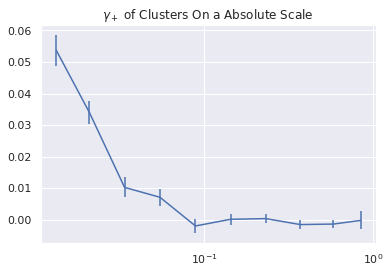

Aggregated xi:
[-29.0869 -37.1669 -17.4546 -19.7759   8.8524  -1.0438  -3.9795  21.3482
  16.7836   0.5341]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -2339.7683  -4225.4973  -5762.9318  -8055.5608 -10923.8734 -14049.2476
 -15867.7848 -13899.7473  -6648.0985   -431.7922]
------------------------------------------------------------------------------
Aggregated npairs:
[  542.  1093.  1702.  2774.  4515.  7236. 10852. 14040. 12336.  2581.]
------------------------------------------------------------------------------
Mean xi:
[-0.0537 -0.034  -0.0103 -0.0071  0.002  -0.0001 -0.0004  0.0015  0.0014
  0.0002]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3169 -3.866  -3.386  -2.904  -2.4195 -1.9416 -1.4622 -0.99   -0.5389
 -0.1673]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

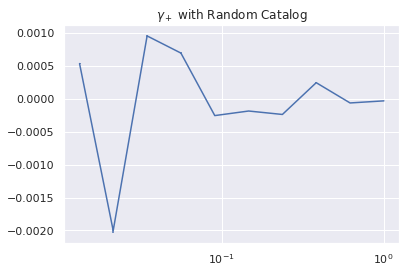

[ 5.3807e-04 -2.0032e-03  9.5860e-04  6.9755e-04 -2.5362e-04 -1.8407e-04
 -2.3639e-04  2.4706e-04 -6.1347e-05 -2.9438e-05]
[-8.3424e-06  3.1058e-05 -1.4862e-05 -1.0815e-05  3.9322e-06  2.8539e-06
  3.6650e-06 -3.8305e-06  9.5114e-07  4.5641e-07]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

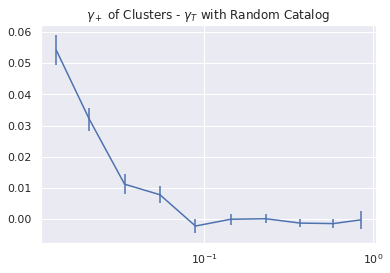

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

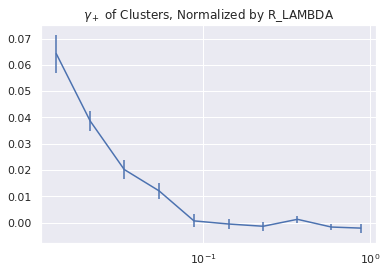

Aggregated xi:
[-17.9156 -32.5685 -27.1629 -26.6285  -2.3603   2.9441  12.0163 -16.2176
  24.3804  15.9425]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -1208.2312  -3253.3502  -4558.3977  -6418.4636  -8367.6825 -11202.5761
 -13017.156  -12765.1839  -7855.7628  -1015.8311]
------------------------------------------------------------------------------
Aggregated npairs:
[  279.   842.  1343.  2204.  3441.  5737.  8817. 12713. 14675.  7720.]
------------------------------------------------------------------------------
Mean xi:
[-0.0642 -0.0387 -0.0202 -0.0121 -0.0007  0.0005  0.0014 -0.0013  0.0017
  0.0021]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3306 -3.8638 -3.3942 -2.9122 -2.4318 -1.9527 -1.4764 -1.0041 -0.5353
 -0.1316]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)